#  SARIMAX & VAR model

In [ ]:
# For data reading | manipulation :
import pandas as pd 

# For reading the array :
import numpy as np

# For visualize the data and plottting patameters :
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,8]
import seaborn as sns

# To suppress warnings :
from warnings import filterwarnings
filterwarnings('ignore')

# Import train-test split :
from sklearn.model_selection import train_test_split

# Import 'stats' libraries for modeling :
from scipy import stats
import statsmodels.api as sm
from statsmodels.api import OLS

# To scaled the data :
from sklearn.preprocessing import StandardScaler

# To check the accuracy of model :
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Import Statsmodels :
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the data :
AQI_Dhaka_city_hour = pd.read_csv('Dhaka Air Quality (2016-2023).csv')


# Print the first five observations to see the data structure :
AQI_Dhaka_city_hour.head()

,Date,Hour,NowCastConc,RawConc,AQI,AQICategory,QCName
0,1/3/2016 3:00,3,251.4,289.0,302.0,Hazardous,Valid
1,1/3/2016 4:00,4,246.0,240.0,296.0,Very Unhealthy,Valid
2,1/3/2016 5:00,5,264.0,290.0,314.0,Hazardous,Valid
3,1/3/2016 6:00,6,256.8,245.0,307.0,Hazardous,Valid
4,1/3/2016 7:00,7,238.2,205.0,288.0,Very Unhealthy,Valid


In [ ]:
# Checking shape and data types of the data :

AQI_Dhaka_city_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58211 entries, 0 to 58210
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         58211 non-null  object 
 1   Hour         58211 non-null  int64  
 2   NowCastConc  57778 non-null  float64
 3   RawConc      57533 non-null  float64
 4   AQI          57780 non-null  float64
 5   AQICategory  57784 non-null  object 
 6   QCName       58205 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 3.1+ MB


In [ ]:
# Summary Statistics of the numeric data :

AQI_Dhaka_city_hour.describe()

,Hour,NowCastConc,RawConc,AQI
count,58211.000000,57778.000000,57533.000000,57780.000000
mean,11.495405,90.233071,91.815167,155.390966
std,6.923331,75.963130,88.009600,72.735165
min,0.000000,-0.300000,-15.000000,0.000000
25%,5.000000,34.500000,33.000000,98.000000
50%,11.000000,63.200000,63.000000,155.000000
75%,17.000000,128.200000,128.000000,189.000000
max,23.000000,844.900000,985.000000,728.000000


In [ ]:
# Checking for the missing values and its precentage :

values = AQI_Dhaka_city_hour.isnull().sum()
percentage = 100*AQI_Dhaka_city_hour.isnull().sum()/len(AQI_Dhaka_city_hour)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('OrRd')

,No of missing values,Percent of missing values
RawConc,678,1.160000
NowCastConc,433,0.740000
AQI,431,0.740000
AQICategory,427,0.730000
QCName,6,0.010000


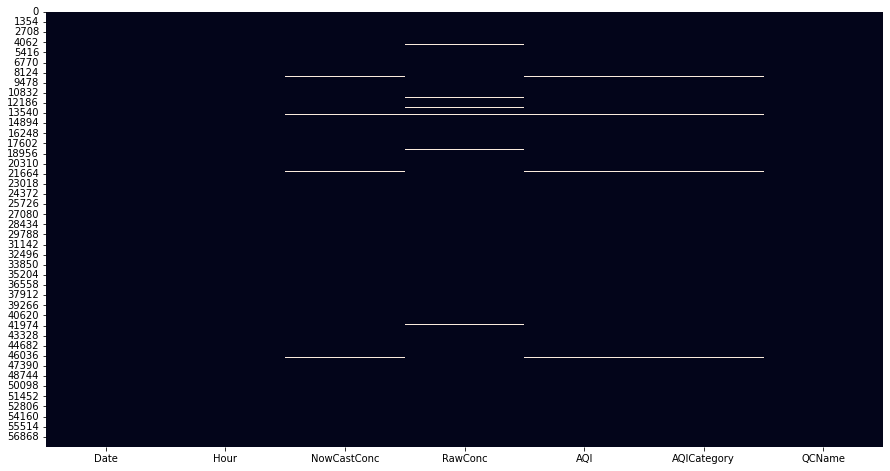

In [ ]:
# Check the missing values with heatmap :

sns.heatmap(AQI_Dhaka_city_hour.isnull(), cbar=False)
plt.show()

In [ ]:
AQI_Dhaka_city_hour.groupby(['Date','Hour'])['AQI'].mean()

Date            Hour
1/1/2017 0:00   0       339.0
1/1/2017 10:00  10      310.0
1/1/2017 11:00  11      284.0
1/1/2017 12:00  12      268.0
1/1/2017 13:00  13      213.0
                        ...  
9/9/2022 5:00   5       146.0
9/9/2022 6:00   6       119.0
9/9/2022 7:00   7       120.0
9/9/2022 8:00   8       137.0
9/9/2022 9:00   9       156.0
Name: AQI, Length: 57412, dtype: float64

In [ ]:
# Converting Datetime variable into datetime data type :

AQI_Dhaka_city_hour['Date'] = AQI_Dhaka_city_hour['Date'].apply(pd.to_datetime)

In [ ]:
# Check whether it is converted or not :

AQI_Dhaka_city_hour.dtypes

Date           datetime64[ns]
Hour                    int64
NowCastConc           float64
RawConc               float64
AQI                   float64
AQICategory            object
QCName                 object
dtype: object

In [ ]:
# Impute the missing values by grouping city with and average of 5 days:

data_fill = AQI_Dhaka_city_hour.iloc[:, :15].fillna(AQI_Dhaka_city_hour.iloc[:, :15].groupby(['Hour', pd.Grouper(key='Date', freq='5D')]).transform('mean'))

In [ ]:
# After inputing missing values by day checking for the missing values :

values = data_fill.isnull().sum()
percentage = 100*data_fill.isnull().sum()/len(data_fill)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('Purples')

,No of missing values,Percent of missing values
AQICategory,427,0.730000
RawConc,100,0.170000
NowCastConc,37,0.060000
AQI,37,0.060000
QCName,6,0.010000


In [ ]:
# Impute the missing values by grouping city and month :

data_fill = data_fill.fillna(data_fill.groupby(['Hour', pd.Grouper(key='Date', freq='M')]).transform('mean'))

In [ ]:
# After inputing missing values by month check for the missing values :

values = data_fill.isnull().sum()
percentage = 100*data_fill.isnull().sum()/len(data_fill)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('Blues')

,No of missing values,Percent of missing values
AQICategory,427,0.730000
QCName,6,0.010000


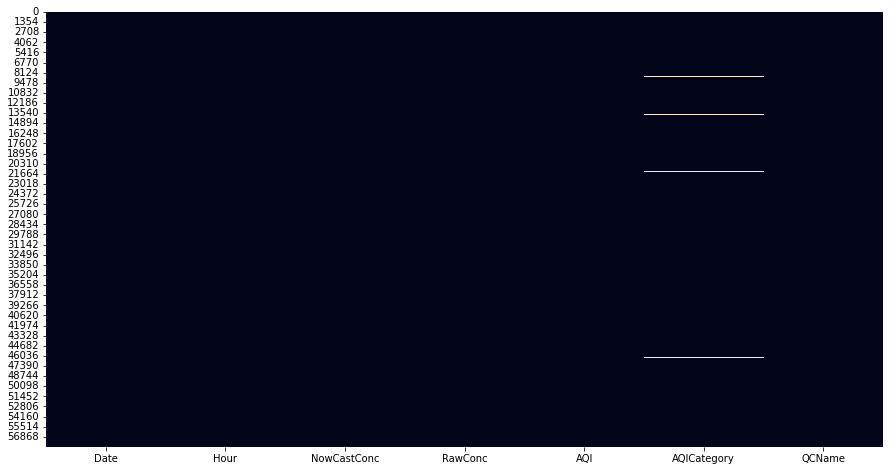

In [ ]:
sns.heatmap(data_fill.isnull(), cbar=False)
plt.show()

In [ ]:
# Imputing missing values by beckward fill :

data_fill = data_fill.fillna(method = 'bfill',axis=0)

In [ ]:
# Still data is missing in the columns, hence using forward fill to impute this :

data_fill = data_fill.fillna(method = 'ffill',axis=0)

In [ ]:
# After inputing missing values by bfill abd ffill:

values = data_fill.isnull().sum()
percentage = 100*data_fill.isnull().sum()/len(data_fill)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('Blues')

,No of missing values,Percent of missing values


In [ ]:
# After imputing missing values, check summary statistics of the data :

data_fill.describe()

,Hour,NowCastConc,RawConc,AQI
count,58211.000000,58211.000000,58211.000000,58211.000000
mean,11.495405,90.246698,91.858581,155.410326
std,6.923331,75.871753,87.788322,72.655011
min,0.000000,-0.300000,-15.000000,0.000000
25%,5.000000,34.500000,33.000000,98.000000
50%,11.000000,63.400000,63.000000,155.000000
75%,17.000000,128.100000,128.000000,188.000000
max,23.000000,844.900000,985.000000,728.000000


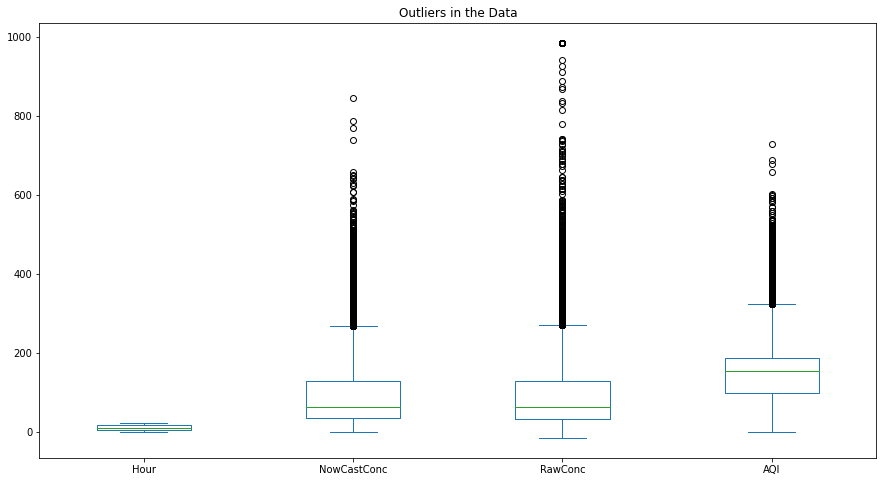

<Figure size 1080x576 with 0 Axes>

In [ ]:
# Checking for outliers :

data_fill.plot(kind='box')
plt.title("Outliers in the Data")
plt.show()
plt.savefig('Outliers.png', dpi=300, bbox_inches='tight')

In [ ]:
# In this we are not concidering the AQI_Bucket column, because it is not nessasary for our analysis.
# Here, we do analysis on all over Dhaka, so Aggregating the data into month wise and creating the new dataframe.

AQI_df = data_fill.groupby(['Hour', (data_fill.Date.dt.strftime('%Y-%m'))]).mean()

# Reset index :
AQI_df = AQI_df.reset_index()

# Check the First 5 observation :
AQI_df.head()

,Hour,Date,NowCastConc,RawConc,AQI
0,0,2016-01,53.155556,55.111111,126.111111
1,0,2016-02,85.450000,88.200000,152.100000
2,0,2016-03,95.706897,100.137931,166.517241
3,0,2016-04,49.967857,48.392857,123.642857
4,0,2016-05,50.803448,49.655172,119.275862


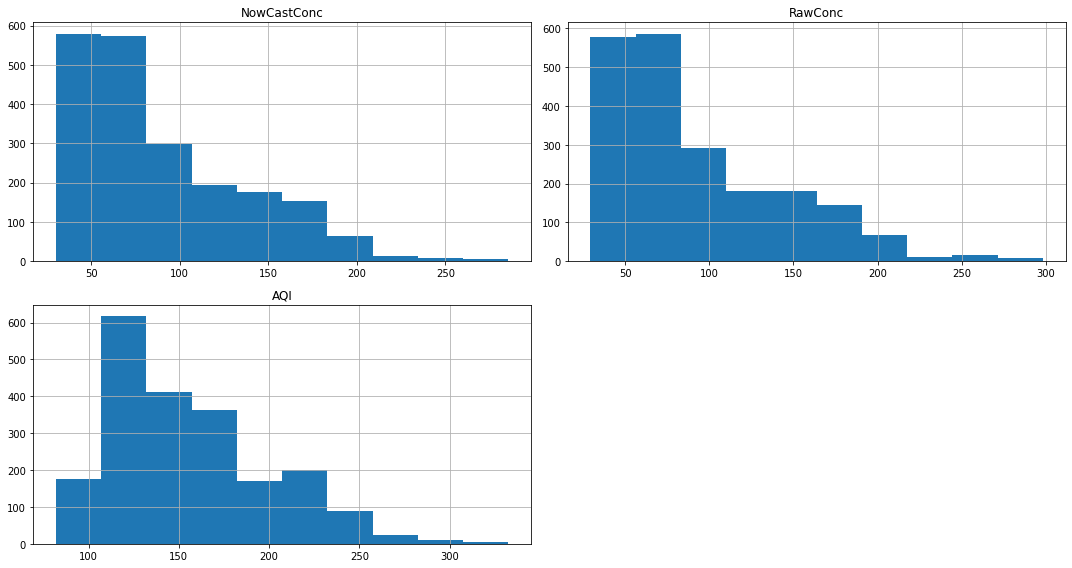

Skewness :
 NowCastConc    1.094924
RawConc        1.115514
AQI            0.856105
dtype: float64


<Figure size 1080x576 with 0 Axes>

In [ ]:
# Check the distribution of the all numerical columns and print skewness of the data :

AQI_df.drop(['Hour', 'Date'], axis=1).hist()
plt.tight_layout()
plt.title("Distribution of Data")
plt.show()
plt.savefig('Distribution of data.png')
# Print the skewness of the data :
print('Skewness :\n', AQI_df.drop(['Hour', 'Date'], axis=1).skew())

The impact of  NowCastConc on AQI


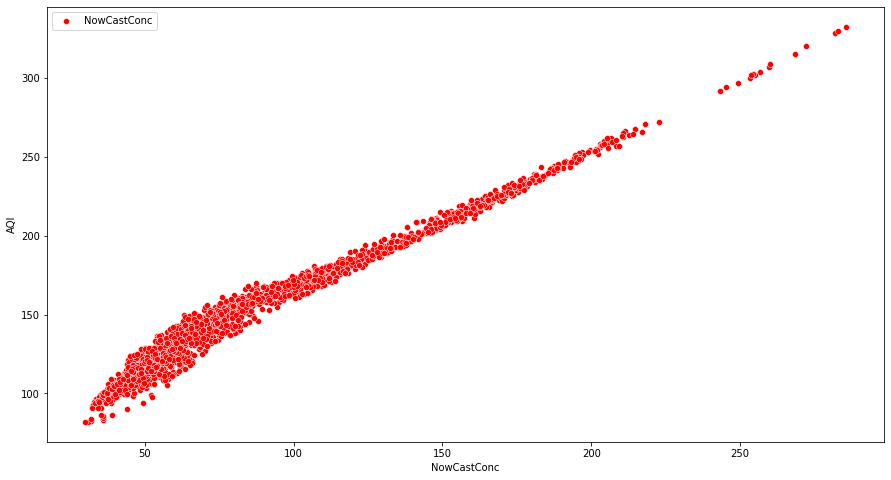

The impact of  RawConc on AQI


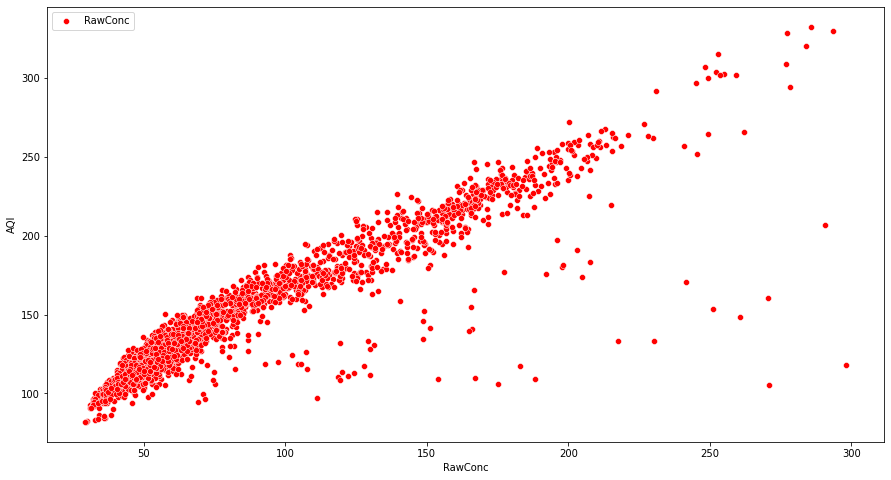

The impact of  AQI on AQI


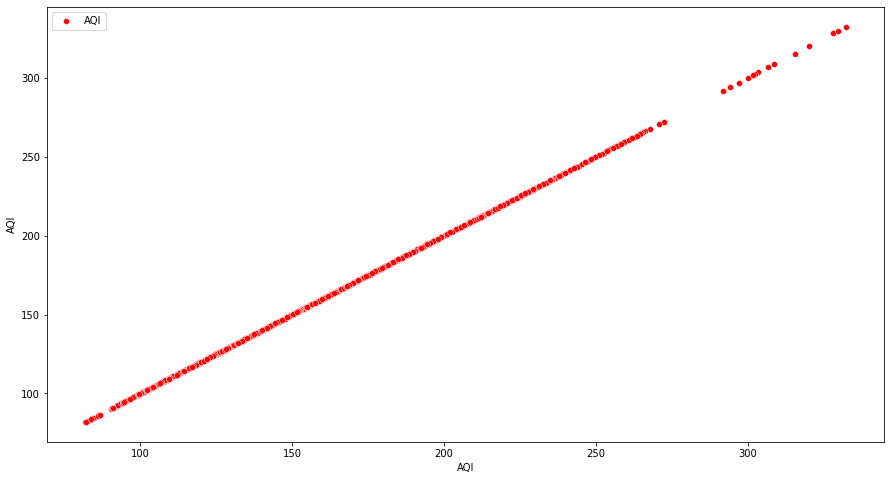

In [ ]:
# Check the effect of all pollutants on AQI :

for i in AQI_df.iloc[:, 2:13]:
    print('The impact of ', i, 'on AQI')
    sns.scatterplot(x = i, y ='AQI', data = AQI_df,marker="o",sizes=200,color="r",label=i)
    plt.legend()
    plt.show()

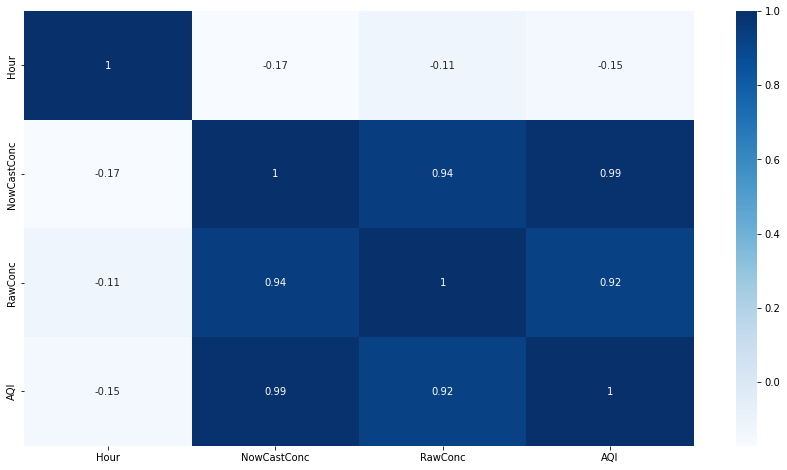

In [ ]:
# Correlation of the numerical data with heatmap :

sns.heatmap(AQI_df.corr(), annot=True, cmap='Blues')
plt.show()

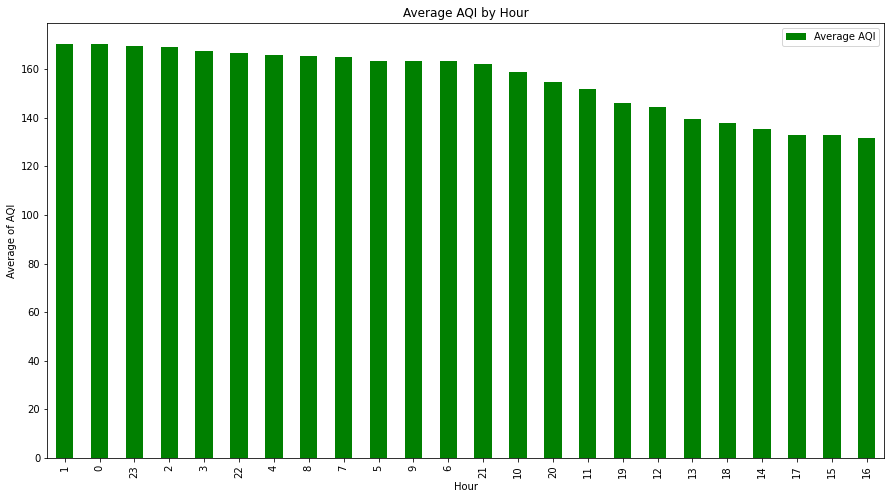

In [ ]:
# Check the Hourwise average of AQI :

AQI_df.groupby('Hour')['AQI'].mean().sort_values(ascending=False).plot(kind='bar',color="g",label="Average AQI")
plt.ylabel('Average of AQI')
plt.title("Average AQI by Hour")
plt.legend()
plt.show()

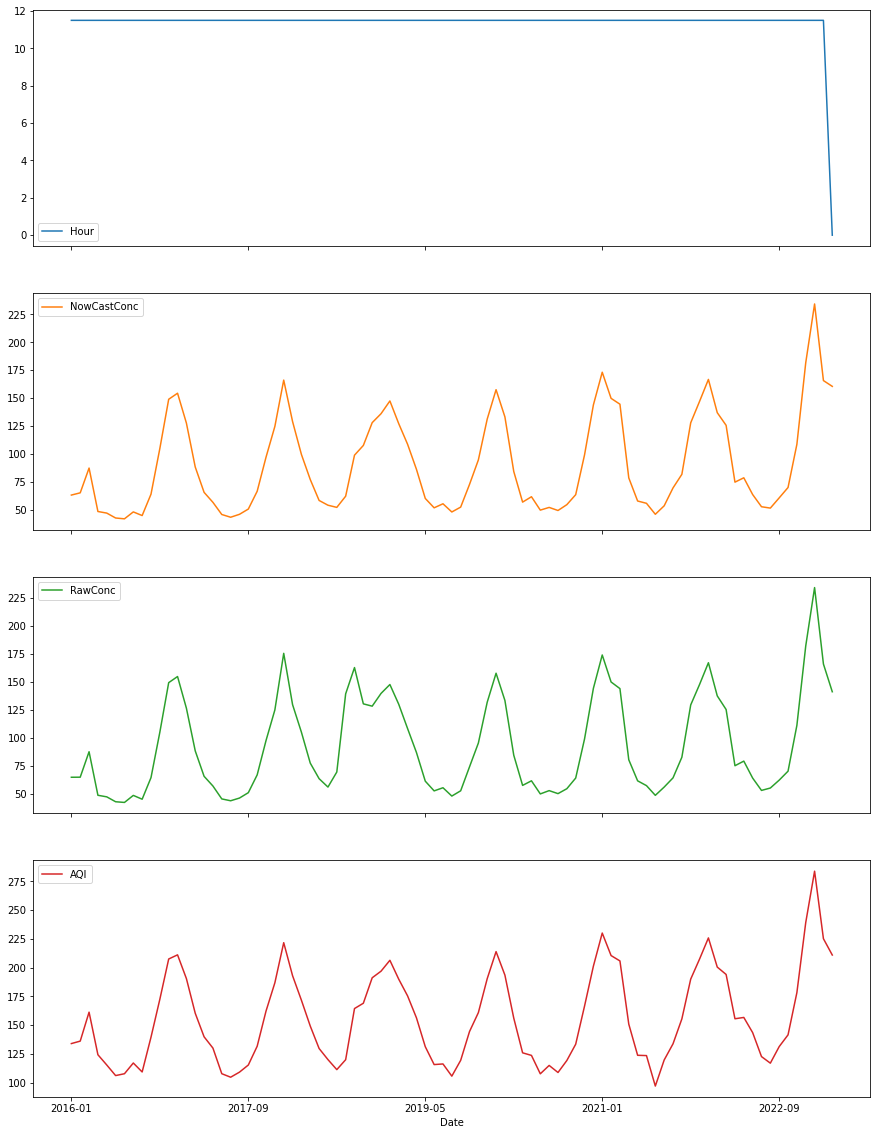

In [ ]:
# Yearly and Monthly Visualisation.

AQI_df.groupby(['Date']).mean().plot(kind='line', figsize=(15,20), subplots=True)

plt.show()

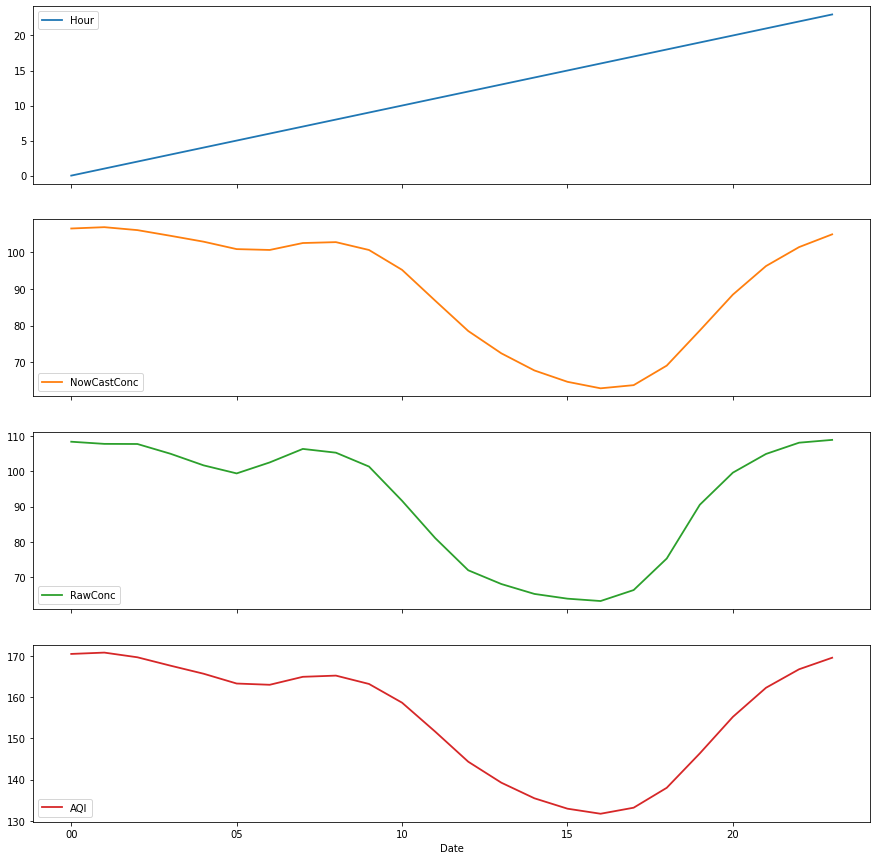

In [ ]:
# Hourly Visualisations

data_fill.groupby(data_fill.Date.dt.strftime('%H')).mean().plot(kind='line', figsize=(15,15), subplots=True,linewidth=1.8)
plt.show()

In [ ]:
# First seperate target and independent variables :
X = AQI_df.drop(['Hour', 'Date', 'AQI'], axis=1)
X = sm.add_constant(X)
y = AQI_df.AQI

# Fitting the model
model = OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AQI   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 4.730e+04
Date:                Sat, 04 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:28:39   Log-Likelihood:                -6748.8
No. Observations:                2065   AIC:                         1.350e+04
Df Residuals:                    2062   BIC:                         1.352e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          72.8081      0.304    239.814      0.000      72.213      73.403
NowCastConc     0.9509      0.008    111.926      0.000       0.934       0.968
RawConc        -0.0340      0.008     -4.269      0.000      -0.050      -0.018
==============================================================================
Omnibus:                       11.338   Durbin-Watson:                   1.092
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.415
Skew:                          -0.018   Prob(JB):                     0.000450
Kurtosis:                       3.422   Cond. No.                         316.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Print significant variables which are most affect on AQI :

significant = model.pvalues[model.pvalues < 0.05].sort_values(ascending=True)

print('Significant vaeiables which more affect on AQI :\n', significant)

Significant vaeiables which more affect on AQI :
 const          0.000000
NowCastConc    0.000000
RawConc        0.000021
dtype: float64


In [ ]:
# Import the library :
from statsmodels.tsa.stattools import adfuller

# Perform the test :
adfuller(AQI_df.AQI)

(-4.321225885674882,
 0.00040808199463924106,
 25,
 2039,
 {'1%': -3.4335611582014476,
  '5%': -2.8629585317012416,
  '10%': -2.567525163136879},
 17630.740658410665)

In [ ]:
# Before this, Convert Datetime variable into Datetime data type in new dataframe AQI_df :

AQI_df['Date'] = AQI_df['Date'].apply(pd.to_datetime)

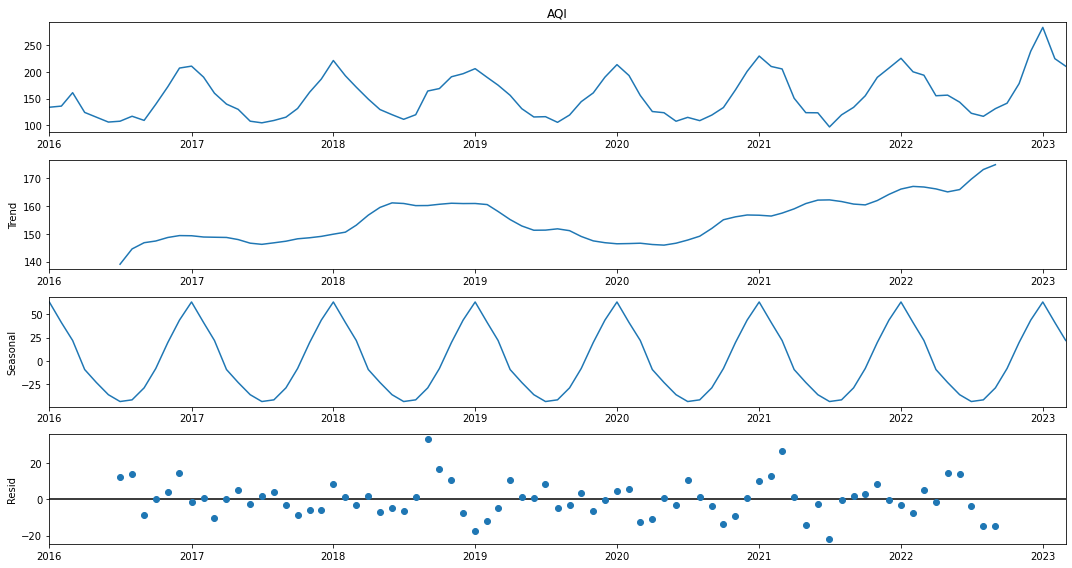

In [ ]:
# Remove city from the dataframe as it is a Categorical column :
df = AQI_df.drop('Hour', axis=1)

# Set Datetime as index :
df.set_index('Date', inplace=True)

# Do groupby Datetime for average of AQI :
df1 = df.groupby('Date')['AQI'].mean()

# Decompose the time series :
decomposition = sm.tsa.seasonal_decompose(df1, model='additive')
fig = decomposition.plot()
plt.show()

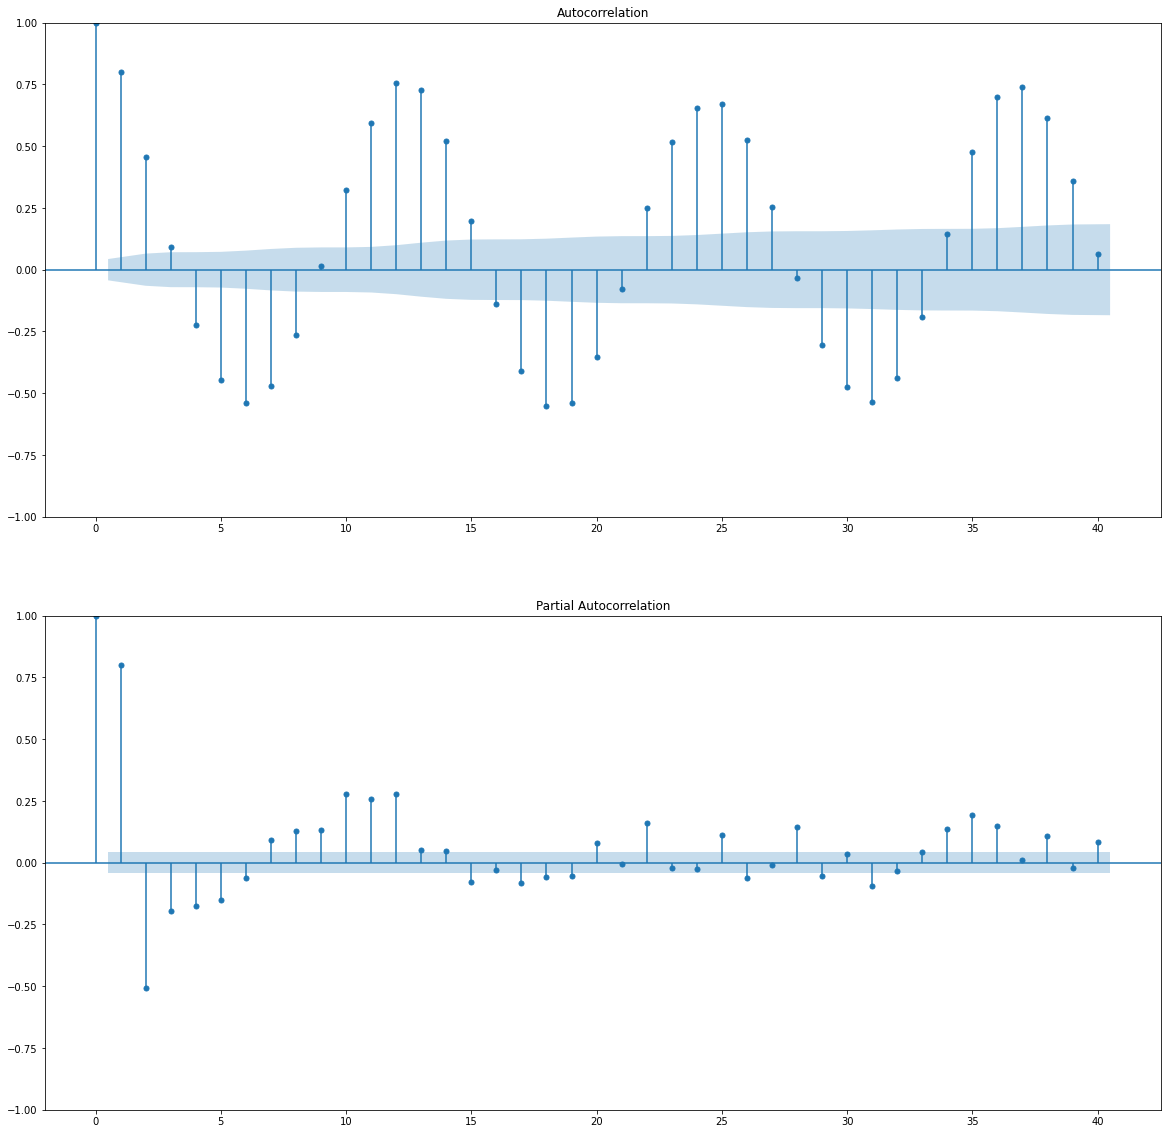

In [ ]:
# Import library ACF and PACF :
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# PLot :
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(df.AQI,lags=40,ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.AQI,lags=40,ax=ax2)
plt.show()

In [ ]:
# Defining Function for Accuracy metrics
def forecast_accuracy(forecast, actual):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    mape = np.mean(np.abs((actual - forecast)/actual))*100  # MAPE
    rmse = np.sqrt(mean_squared_error(actual,forecast))  # RMSE
    return({'mape':mape, 'rmse':rmse})

In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def VAR_accuracy(predicted, valid):
    from sklearn.metrics import mean_squared_error
    for i in df.columns:
        print("rmse value for ",i,"is :' ",np.sqrt(mean_squared_error(valid[i], predicted[i])))
        print("mape value for ",i,"is :' ", MAPE(valid[i].values,predicted[i]), end = '\n\n')

In [ ]:
def VAR_AQI_MAPE(predicted, valid):
    return (MAPE(valid['AQI'].values,predicted['AQI']))
    

In [ ]:
def VAR_AQI_RMSE(predicted, valid):
    return (np.sqrt(mean_squared_error(valid['AQI'], predicted['AQI'])))

In [ ]:
#Month Wise Analysis
# Prepare the data for Analysis :   (Purpose to make simple data for Time series)

month = data_fill.groupby([pd.Grouper(key='Date', freq='m')]).mean()

# Reset Index
month = month.reset_index()

# Setting Index
month = month.set_index('Date')

# Dropping the categorical
#week = week.drop('Hour', axis = 1)

# Check the dimensions of the data :
print(month.shape)

month.head()

(87, 4)


,Hour,NowCastConc,RawConc,AQI
Date,,,,
2016-01-31,11.632911,63.348101,64.648734,134.062236
2016-02-29,11.500000,65.218333,64.595833,136.062500
2016-03-31,11.501437,87.409052,87.347701,161.254310
2016-04-30,11.500000,48.494792,48.415179,124.200893
2016-05-31,11.500000,47.074713,47.010057,115.287356


In [ ]:
#Base Model - ARIMA
#creating Train test split
train_month=month[:int(0.8*(len(month)))]
print('Train shape', train_month.shape)

valid_month=month[int(0.8*(len(month))):]
print('Test shape', valid_month.shape)

Train shape (69, 4)
Test shape (18, 4)


In [ ]:
# Fitting the model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_month.AQI,  order=(1,1,1)) 
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                   69
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -298.009
Date:                Sat, 04 Mar 2023   AIC                            602.018
Time:                        14:28:41   BIC                            608.677
Sample:                    01-31-2016   HQIC                           604.657
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4974      0.246      2.023      0.043       0.016       0.979
ma.L1         -0.0461      0.300     -0.154      0.878      -0.634       0.542
sigma2       373.7502     66.740      5.600      0.000     242.942     504.559
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.01
Prob(Q):                              0.99   Prob(JB):                         0.22
Heteroskedasticity (H):               1.41   Skew:                            -0.51
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.1 MB/s eta 0:00:00


In [ ]:
#Auto - ARIMA (Month wise - Univariate)
# Import the library:
from pmdarima import auto_arima

stepwise_fit = auto_arima(train_month.AQI, trace = True, suppress_warnings = True, seasonal = False)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=611.995, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=892.449, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=628.798, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=812.004, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=610.971, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=618.843, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=611.573, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=706.976, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=615.734, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=613.168, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=597.830, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=613.633, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=608.387, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=576.654, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -281.693
Date:                Sat, 04 Mar 2023   AIC                            575.386
Time:                        14:28:52   BIC                            588.791
Sample:                    01-31-2016   HQIC                           580.704
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     45.9441     11.311      4.062      0.000      23.775      68.113
ar.L1          1.4568      0.218      6.696      0.000       1.030       1.883
ar.L2         -0.5722      0.329     -1.739      0.082      -1.217       0.073
ar.L3         -0.1900      0.182     -1.045      0.296      -0.546       0.166
ma.L1         -0.5529      0.211     -2.615      0.009      -0.967      -0.138
sigma2       197.7987     33.142      5.968      0.000     132.842     262.756
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.95   Prob(JB):                         0.62
Heteroskedasticity (H):               0.98   Skew:                            -0.26
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#SARIMAX Model ( Month wise - Univariate Analysis)
#To consider the seasonality in ARIMA model, we will build SARIMAX model on the basis of ARIMA order.
import statsmodels.api as sm
mod_month = sm.tsa.statespace.SARIMAX(train_month.AQI,
                                order=(3, 0, 2),
                                seasonal_order=(3, 0, 2, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
mod_month.initialize_approximate_diffuse()
result_month = mod_month.fit()
result_month.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                AQI   No. Observations:                   69
Model:             SARIMAX(3, 0, 2)x(3, 0, 2, 12)   Log Likelihood                -415.518
Date:                            Sat, 04 Mar 2023   AIC                            853.035
Time:                                    14:28:58   BIC                            877.611
Sample:                                01-31-2016   HQIC                           862.785
                                     - 09-30-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2667      0.791      1.601      0.109      -0.284       2.817
ar.L2         -0.2602      1.042     -0.250      0.803      -2.302       1.781
ar.L3         -0.1676      0.406     -0.413      0.680      -0.964       0.628
ma.L1         -1.0778      1.659     -0.650      0.516      -4.329       2.173
ma.L2          0.0946      0.706      0.134      0.893      -1.290       1.479
ar.S.L12       0.0779      0.166      0.468      0.640      -0.248       0.404
ar.S.L24       0.2560      0.165      1.553      0.120      -0.067       0.579
ar.S.L36       0.6648      0.154      4.307      0.000       0.362       0.967
ma.S.L12      -0.0094    249.327  -3.77e-05      1.000    -488.681     488.662
ma.S.L24      -0.9888    264.361     -0.004      0.997    -519.128     517.150
sigma2        43.3688   1.16e+04      0.004      0.997   -2.27e+04    2.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                14.20
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):             677.58   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

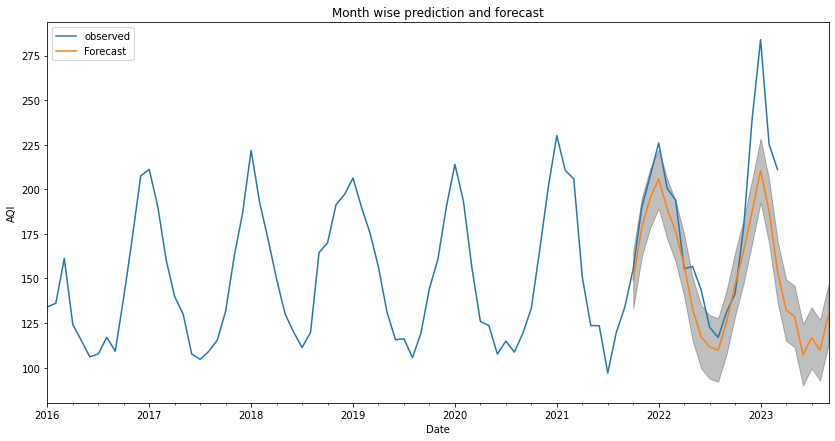

In [ ]:
#On the basis of SARIMAX result we will plot the predicted values of valid set as well as future values of AQI for 2023.
## Forecast for valid set and Future

pred_uc_month = result_month.get_forecast(steps=24)
pred_ci = pred_uc_month.conf_int()
ax = month.AQI.plot(label='observed', figsize=(14, 7))
pred_uc_month.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.title("Month wise prediction and forecast")
plt.legend()
plt.show()

In [ ]:
# Calculate Accuracy Metrics

forecast_accuracy(pred_uc_month.predicted_mean[:18], valid_month.AQI)

{'mape': 10.88609557521429, 'rmse': 29.41702091207996}

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR

# Fitting the VAR model
VAR_model_month=VAR(endog=train_month)
VAR_model_month_fit=VAR_model_month.fit()



In [ ]:
# Predicting on Validation set
predict_month=VAR_model_month_fit.forecast(VAR_model_month_fit.endog,steps=len(valid_month))

pred_month=pd.DataFrame(predict_month,columns=valid_month.columns,index=range(0,len(predict_month)))

In [ ]:
VAR_accuracy(pred_month, valid_month)

rmse value for  NowCastConc is :'  62.80987828981185
mape value for  NowCastConc is :'  38.837414541791325

rmse value for  RawConc is :'  60.2094452849837
mape value for  RawConc is :'  39.14586865727524

rmse value for  AQI is :'  57.95783252328217
mape value for  AQI is :'  23.04094161586495



In [ ]:
VAR_AQI_MAPE(pred_month, valid_month)

23.04094161586495

In [ ]:
VAR_AQI_RMSE(pred_month, valid_month)


57.95783252328217

In [ ]:

# Prepare the data for Analysis :   (Purpose to make simple data for Time series)

week = data_fill.groupby([pd.Grouper(key='Date', freq='w')]).mean()
week = week.fillna(method='ffill')
# Reset Index
week = week.reset_index()

# Setting Index
week = week.set_index('Date')

# Dropping the categorical
week = week.drop('Hour', axis = 1)

# Check the dimensions of the data :
print(week.shape)

# Check first five values
week.head(10)

(375, 3)


,NowCastConc,RawConc,AQI
Date,,,
2016-01-03,187.900000,188.523810,242.809524
2016-01-10,43.726190,45.433036,115.075893
2016-01-17,77.533333,77.708333,152.937500
2016-01-24,77.533333,77.708333,152.937500
2016-01-31,77.533333,77.708333,152.937500
2016-02-07,76.254167,74.666667,148.266667
2016-02-14,54.182500,54.525000,123.858333
2016-02-21,54.182500,54.525000,123.858333
2016-02-28,54.182500,54.525000,123.858333


In [ ]:
#creating Train test split
train_week=week[:int(0.8*(len(week)))]
print('Train shape', train_week.shape)

valid_week=week[int(0.8*(len(week))):]
print('Test shape', valid_week.shape)

Train shape (300, 3)
Test shape (75, 3)


In [ ]:
#Auto ARIMA on week wise data
from pmdarima import auto_arima

stepwise_fit_week = auto_arima(train_week.AQI, trace = True, suppress_warnings = True, seasonal = False)

stepwise_fit_week.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3044.853, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3887.838, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3190.470, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3626.356, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3078.117, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3078.154, Time=0.21 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3015.193, Time=0.28 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3055.363, Time=0.31 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2990.183, Time=0.16 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2997.808, Time=0.17 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=2986.695, Time=0.57 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=2979.163, Time=0.50 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(5, 0, 1)   Log Likelihood               -1477.911
Date:                Sat, 04 Mar 2023   AIC                           2971.822
Time:                        14:30:03   BIC                           3001.452
Sample:                    01-03-2016   HQIC                          2983.680
                         - 09-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     38.0087     16.424      2.314      0.021       5.819      70.198
ar.L1         -0.6752      0.051    -13.326      0.000      -0.774      -0.576
ar.L2          0.2115      0.047      4.477      0.000       0.119       0.304
ar.L3          0.0768      0.050      1.524      0.127      -0.022       0.176
ar.L4          0.5476      0.051     10.675      0.000       0.447       0.648
ar.L5          0.5786      0.045     12.898      0.000       0.491       0.667
ma.L1          0.9050      0.044     20.599      0.000       0.819       0.991
sigma2      1070.7734     91.466     11.707      0.000     891.504    1250.043
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 5.30
Prob(Q):                              0.74   Prob(JB):                         0.07
Heteroskedasticity (H):               1.33   Skew:                             0.33
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#SARIMAX Model ( Week wise - Univariate Analysis)
#To consider the seasonality in ARIMA model, we will build SARIMAX model on the basis of ARIMA order.
mod_week = sm.tsa.statespace.SARIMAX(train_week.AQI,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
mod_week.initialize_approximate_diffuse()
result_week = mod_week.fit()
result_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 AQI   No. Observations:                  300
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood               -1221.622
Date:                             Sat, 04 Mar 2023   AIC                           2451.243
Time:                                     14:30:17   BIC                           2465.281
Sample:                                 01-03-2016   HQIC                          2456.895
                                      - 09-26-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0995      0.061     -1.620      0.105      -0.220       0.021
ma.L1         -0.8187      0.045    -18.396      0.000      -0.906      -0.732
ar.S.L52      -0.0099      0.008     -1.172      0.241      -0.027       0.007
sigma2      1137.0232    103.422     10.994      0.000     934.320    1339.726
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.64   Prob(JB):                         0.49
Heteroskedasticity (H):               0.92   Skew:                             0.06
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

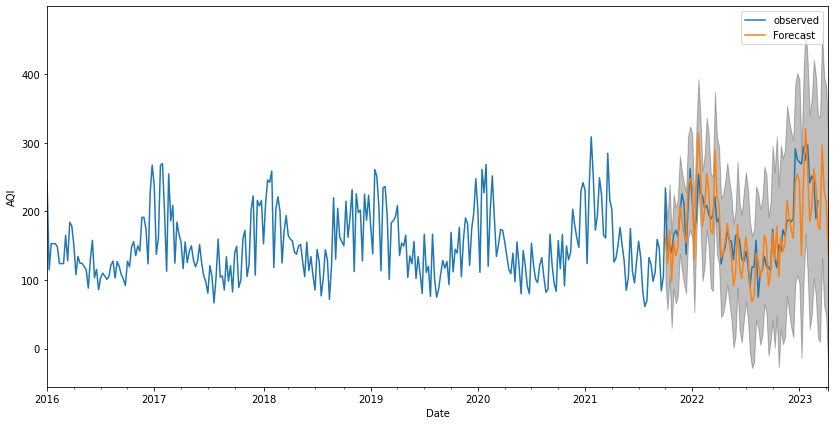

In [ ]:
## Forecast for valid set and Future

pred_uc_week = result_week.get_forecast(steps=80)
pred_ci = pred_uc_week.conf_int()
ax = week.AQI.plot(label='observed', figsize=(14, 7))
pred_uc_week.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

In [ ]:
# Calculate Accuracy Metrics

forecast_accuracy(pred_uc_week.predicted_mean[:len(valid_week.AQI)], valid_week.AQI)

{'mape': 16.71850153639512, 'rmse': 36.58772235383717}

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR

# Fitting the VAR model
VAR_model_week=VAR(endog=train_week)
VAR_model_week_fit=VAR_model_week.fit()

# Predicting on Validation set
predict_week=VAR_model_week_fit.forecast(VAR_model_week_fit.endog,steps=len(valid_week))

pred_week=pd.DataFrame(predict_week,columns=df.columns,index=range(0,len(predict_week)))

In [ ]:
VAR_accuracy(pred_week, valid_week)


rmse value for  NowCastConc is :'  66.83425010691313
mape value for  NowCastConc is :'  47.44999415969162

rmse value for  RawConc is :'  60.46391337660701
mape value for  RawConc is :'  52.560670795138854

rmse value for  AQI is :'  61.26992992089746
mape value for  AQI is :'  24.466373808858442



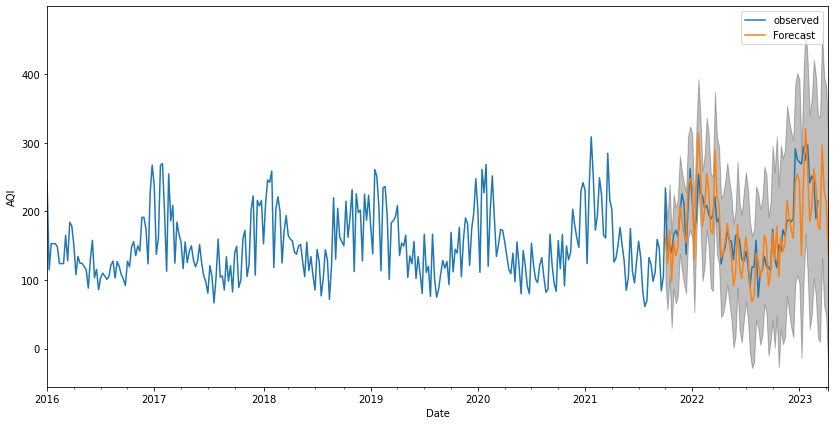

In [ ]:
## Forecast for valid set and Future

pred_uc_week = result_week.get_forecast(steps=80)
pred_ci = pred_uc_week.conf_int()
ax = week.AQI.plot(label='observed', figsize=(14, 7))
pred_uc_week.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

# Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the AQI dataset
df = pd.read_csv('Dhaka Air Quality 4 (2016-2023).csv', parse_dates=['Date'], index_col='Date')


In [ ]:
# Define the number of time steps to use for prediction
n_steps =80

# Create the time lagged features
df_shifted = df.copy()
for i in range(1, n_steps+1):
    df_shifted[f't-{i}'] = df_shifted['AQI'].shift(i)

# Drop rows with missing values
df_shifted.dropna(inplace=True)

# Split the data into training and testing sets
X = df_shifted.iloc[:, :-1]
y = df_shifted.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
train_scores = []
test_scores = []
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
train_scores.append(rf.score(X_train, y_train))
test_scores.append(rf.score(X_test, y_test))

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
y_pred = rf.predict(X_test)
# Compute the mean absolute error (MAE) and root mean squared error (RMSE)
rmape = mean_absolute_percentage_error(y_test, y_pred)
rrmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'MAPE: {rmape:.2f}, RMSE: {rrmse:.2f}')


MAPE: 8638838523765.69, RMSE: 15.59


In [ ]:
y_pred = rf.predict(X_test)
y_pred

array([ 53.22, 164.2 , 110.45, ..., 365.14,  89.98, 154.09])

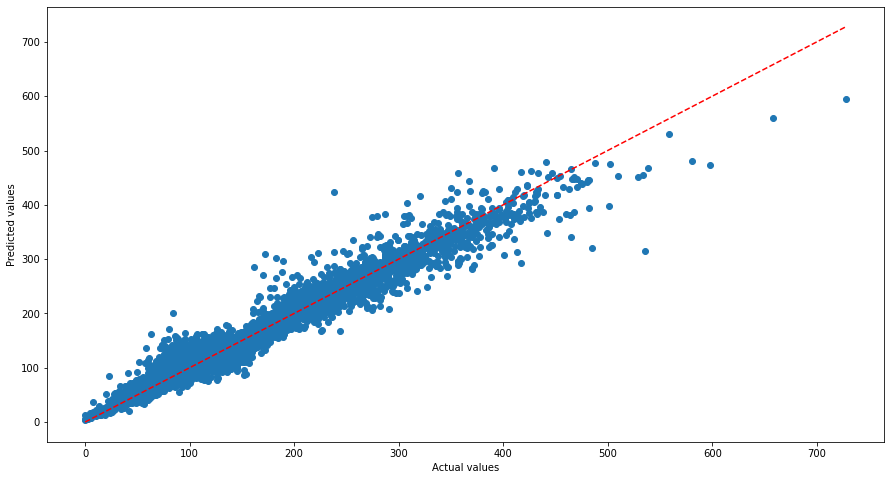

In [ ]:
# Plot predicted vs actual values
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='r')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

# Decision Tree

In [ ]:
# Import required libraries


import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the AQI dataset
df = pd.read_csv('Dhaka Air Quality 4 (2016-2023).csv', parse_dates=['Date'], index_col='Date')

In [ ]:

# Split the data into training and testing sets
#train_data = df_shifted.iloc[:, :-1] 
#test_data = df_shifted.iloc[:, -1]

#X_train, x_test, y_train, y_test = train_test_split(train_data, test_data, test_size=0.2, random_state=42)

# Define the number of time steps to use for prediction
n_steps = 80

# Create the time lagged features
df_shifted = df.copy()
for i in range(1, n_steps+1):
    df_shifted[f't-{i}'] = df_shifted['AQI'].shift(i)

# Drop rows with missing values
df_shifted.dropna(inplace=True)

# Split the data into training and testing sets
X = df_shifted.iloc[:, :-1]
y = df_shifted.iloc[:, -1]
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

df = DecisionTreeRegressor(random_state=42)
df.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

In [ ]:
# Evaluate the model
predicted_test_y = df.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predicted_test_y))
mape = mean_absolute_percentage_error(y_test, predicted_test_y) * 100

# Print the RMSE and MAPE values
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 21.627726164094444
MAPE: 1107543400482780.9


# Total Comparision

In [ ]:
res = [["SARIMAX Month wise", (forecast_accuracy(pred_uc_month.predicted_mean[:18], valid_month.AQI)['rmse']), forecast_accuracy(pred_uc_month.predicted_mean[:18], valid_month.AQI)['mape']],
       ["VAR MONTH Wise", (VAR_AQI_RMSE(pred_month, valid_month)), VAR_AQI_MAPE(pred_month, valid_month)],
       ["SARIMAX Week Wise", (forecast_accuracy(pred_uc_week.predicted_mean[:len(valid_week.AQI)], valid_week.AQI)['rmse']), forecast_accuracy(pred_uc_week.predicted_mean[:len(valid_week.AQI)], valid_week.AQI)['mape']],
       ["VAR week Wise", (VAR_AQI_RMSE(pred_week, valid_week)), VAR_AQI_MAPE(pred_week, valid_week)]]
   #    ["Random Forest", (rrmse), (rmape)],
   #    ["Decision Tree", (rmse), (mape)]]

In [ ]:
results=pd.DataFrame(res,columns=["Model_Name","RMSE","MAPE"])

In [ ]:
# Define the CSS styles for the different rows
styles = [{'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', 'red')]},
          {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', 'black')]}]

In [ ]:
# Apply the CSS styles to the DataFrame
results.style.set_table_styles(styles)

,Model_Name,RMSE,MAPE
0,SARIMAX Month wise,29.417021,10.886096
1,VAR MONTH Wise,57.957833,23.040942
2,SARIMAX Week Wise,36.587722,16.718502
3,VAR week Wise,61.269930,24.466374


We can see that the RMSE and MAPE values of SARIMAX model are less than the other models.
It means SARIMAX model is performing best in forecasting AQI values.
We have chosen SARIMAX model as our final model, therefore the forecasted values are visualised through graphical respresentation.